In [33]:

import numpy as np 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from load_clean_data import load_data
from sklearn.linear_model import LogisticRegression
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics



In [34]:
df_tested_data = load_data("tested_molecules_with_descriptors.csv")

df_descriptors = df_tested_data[['PKM2_inhibition', 'ERK2_inhibition']]
df_smiles = df_tested_data["SMILES"]

df_tested_data = df_tested_data.drop(columns=['PKM2_inhibition', 'ERK2_inhibition', 'SMILES'])

# remove columns of zero variance
zero_variance_columns = df_tested_data.columns[df_tested_data.nunique() <= 1]
df_tested_data = df_tested_data.drop(columns=zero_variance_columns)

scalerminmax = MinMaxScaler()
df_scaled = scalerminmax.fit_transform(df_tested_data)

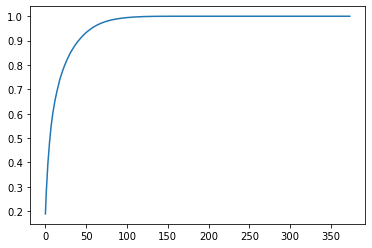

In [35]:
# Split the data into X and y
y = df_descriptors.pop('PKM2_inhibition')
X = df_scaled
 
# Split the data into training and test data set

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=42)
 
# Decide the number of PCA components based on the retained information
pca = PCA()
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(explained_variance)

# Determine the number of components needed to explain 90% of the variance
desired_variance = 0.90
num_components = (np.argmax(explained_variance >= desired_variance) + 1)
#loose components who have too little influence
pca=PCA(n_components=num_components)

tested_mol_pca = pca.fit_transform(X_train)

#corr_mat = np.corrcoef(tested_mol_pca.transpose())
#plt.figure(figsize=[15,8])
#sns.heatmap(corr_mat)
#plt.show()




In [36]:
df_test_pca = pca.transform(X_test)
# Train the Logistic Regression model
LR_PCA_Learner = LogisticRegression()
LR_PCA_Model = LR_PCA_Learner.fit(tested_mol_pca, y_train)



<AxesSubplot:xlabel='Probability'>

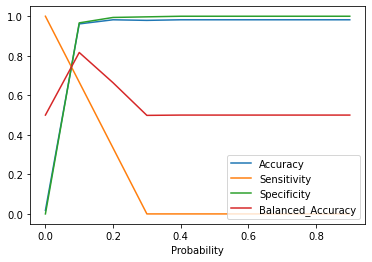

In [37]:
pred_test = LR_PCA_Model.predict_proba(df_test_pca)
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_test[:,1]))
 
# Calculate the predicted probabilities and convert to dataframe
y_pred = LR_PCA_Model.predict_proba(df_test_pca)
y_pred_df = pd.DataFrame(y_pred)
y_pred_1 = y_pred_df.iloc[:,[1]]
y_test_df = pd.DataFrame(y_test)

# Put the index as ID column, remove index from both dataframes and combine them
y_test_df["ID"] = y_test_df.index
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
y_pred_final = y_pred_final.rename(columns = { 1 : "Yes_Prob", "PKM2_inhibition" : "Yes" } )
y_pred_final = y_pred_final.reindex(["ID", "Yes", "Yes_Prob"], axis=1)

# Create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Yes_Prob.map(lambda x: 1 if x > i else 0)
 
# Calculate accuracy, sensitivity & specificity for different cut off points
Probability = pd.DataFrame( columns = ['Probability', 'Accuracy', 'Sensitivity', 'Specificity', "Balanced_Accuracy"])
for i in numbers:
    CM = metrics.confusion_matrix(y_pred_final.Yes, y_pred_final[i] )
    Total = sum(sum(CM))
    Accuracy    = (CM[0,0]+CM[1,1])/Total
    Sensitivity = CM[1,1]/(CM[1,1]+CM[1,0])
    Specificity = CM[0,0]/(CM[0,0]+CM[0,1])
    Balanced_Accuracy=((CM[0,0]/(CM[0,0]+CM[0,1])+CM[1,1]/(CM[1,1]+CM[1,0]))/2)
    Probability.loc[i] =[ i, Accuracy, Sensitivity, Specificity, Balanced_Accuracy]
Probability.plot.line(x='Probability', y=['Accuracy','Sensitivity','Specificity', "Balanced_Accuracy"])


<AxesSubplot:xlabel='Probability'>

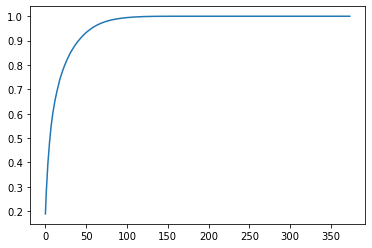

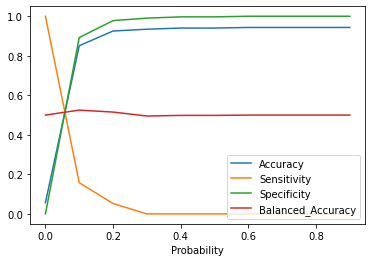

In [38]:
# Split the data into X and y
y = df_descriptors.pop('ERK2_inhibition')
X = df_scaled
 
# Split the data into training and test data set

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=42)
 
# Decide the number of PCA components based on the retained information
pca = PCA()
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_.cumsum()
plt.plot(explained_variance)

# Determine the number of components needed to explain 90% of the variance
desired_variance = 0.90
num_components = (np.argmax(explained_variance >= desired_variance) + 1)
#loose components who have too little influence
pca=PCA(n_components=num_components)

tested_mol_pca = pca.fit_transform(X_train)

#corr_mat = np.corrcoef(tested_mol_pca.transpose())
#plt.figure(figsize=[15,8])
#sns.heatmap(corr_mat)
#plt.show()

df_test_pca = pca.transform(X_test)
# Train the Logistic Regression model
LR_PCA_Learner = LogisticRegression()
LR_PCA_Model = LR_PCA_Learner.fit(tested_mol_pca, y_train)

pred_test = LR_PCA_Model.predict_proba(df_test_pca)
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_test[:,1]))
 
# Calculate the predicted probabilities and convert to dataframe
y_pred = LR_PCA_Model.predict_proba(df_test_pca)
y_pred_df = pd.DataFrame(y_pred)
y_pred_1 = y_pred_df.iloc[:,[1]]
y_test_df = pd.DataFrame(y_test)

# Put the index as ID column, remove index from both dataframes and combine them
y_test_df["ID"] = y_test_df.index
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
y_pred_final = y_pred_final.rename(columns = { 1 : "Yes_Prob", 'ERK2_inhibition' : "Yes" } )
y_pred_final = y_pred_final.reindex(["ID", "Yes", "Yes_Prob"], axis=1)

# Create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Yes_Prob.map(lambda x: 1 if x > i else 0)
 
# Calculate accuracy, sensitivity & specificity for different cut off points

Probability = pd.DataFrame( columns = ['Probability', 'Accuracy', 'Sensitivity', 'Specificity', "Balanced_Accuracy"])
for i in numbers:
    CM = metrics.confusion_matrix(y_pred_final.Yes, y_pred_final[i] )
    Total = sum(sum(CM))
    Accuracy    = (CM[0,0]+CM[1,1])/Total
    Sensitivity = CM[1,1]/(CM[1,1]+CM[1,0])
    Specificity = CM[0,0]/(CM[0,0]+CM[0,1])
    Balanced_Accuracy=((CM[0,0]/(CM[0,0]+CM[0,1])+CM[1,1]/(CM[1,1]+CM[1,0]))/2)
    Probability.loc[i] =[ i, Accuracy, Sensitivity, Specificity, Balanced_Accuracy]
Probability.plot.line(x='Probability', y=['Accuracy','Sensitivity','Specificity', "Balanced_Accuracy"])
